In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import IPython.display as ipd
import sklearn as sk
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.compose

In [2]:
data = pd.read_csv('datasets/bikesharing-day.csv')

data.dteday = pd.to_datetime(data.dteday, format='%Y-%m-%d').dt.normalize()
data.season = data.season.astype('category')
data.mnth = data.mnth.astype('category')
data['day'] = data.dteday.dt.dayofyear
if ('hr' in data):
    data.hr = data.hr.astype('category')
data.weekday = data.weekday.astype('category')
data.weathersit = data.weathersit.astype('category')

data.cnt = data.cnt.astype(float)
data.instant = data.instant.astype(float)

In [3]:
columns = ['instant','day','yr', 'season','weekday','holiday','temp','hum','cnt']
# columns = ['instant','cnt']
projected_data = data.loc[:, columns]
train, test = sk.model_selection.train_test_split(projected_data)

ct = sk.compose.ColumnTransformer([
    ('col',sk.preprocessing.OneHotEncoder(categories='auto'),[
        'season', 'weekday'
    ])
], remainder='passthrough')

In [13]:
ss = sk.preprocessing.StandardScaler()
def regression_model(model, predict, param_grid=None, transform=True):
    print(f'Start {type(model).__name__}')
    variates = train.columns.drop(predict).drop('instant')
    
    trainX = train.loc[:, variates]
    trainy = train.loc[:, [predict]]

    testX = test.loc[:, variates]
    testy = test.loc[:, [predict]]
    
    if transform:
        #ct.fit(projected_data.loc[:,variates]);
        #trainX = ct.transform(trainX)
        #testX = ct.transform(testX)
        trainy = ss.fit_transform(trainy)
    
    if param_grid:
        rgs = sk.model_selection.RandomizedSearchCV(model, param_distributions=param_grid, cv=10, n_iter=4, n_jobs=-1, verbose=4)
        rgs.fit(trainX, trainy.ravel())
    else:
        model.fit(trainX,trainy.ravel())
        
    
    predictedy = ss.inverse_transform((model if not param_grid else rgs).predict(testX))
    print(f'Done {type(model).__name__}')
    return pd.Series({
        'RMSE': np.sqrt(sk.metrics.mean_squared_error(testy,predictedy)),
        'MAE': sk.metrics.mean_absolute_error(testy,predictedy),
        'model': model if not param_grid else rgs
    }, name=type(model).__name__)

In [14]:
param_dist_svr = {'C': np.logspace(-1, 1, 5),
                  'gamma': np.logspace(-1, 1, 5),
                  'kernel': ['rbf','linear']};

In [15]:
import sklearn.linear_model
import sklearn.svm
import sklearn.neural_network
from sklearn.ensemble import GradientBoostingRegressor


models = pd.DataFrame([regression_model(m, 'cnt', transform=True, param_grid=pg) for m,pg in [
    (sk.linear_model.LinearRegression(),None),
    (sk.svm.SVR(), param_dist_svr),
    #(sk.neural_network.MLPRegressor(solver='lbfgs', hidden_layer_sizes=(50,50)),None),
    (GradientBoostingRegressor(),None),
]]).sort_values('RMSE')
models

Start LinearRegression
Done LinearRegression
Start SVR
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   12.8s finished


Done SVR
Start MLPRegressor
Done MLPRegressor
Start GradientBoostingRegressor
Done GradientBoostingRegressor


,RMSE,MAE,model
GradientBoostingRegressor,658.343678,490.276593,([DecisionTreeRegressor(criterion='friedman_ms...
LinearRegression,856.064397,656.147894,"LinearRegression(copy_X=True, fit_intercept=Tr..."
SVR,869.672463,653.330906,"RandomizedSearchCV(cv=2, error_score='raise-de..."
MLPRegressor,1249.415020,957.773351,"MLPRegressor(activation='relu', alpha=0.0001, ..."


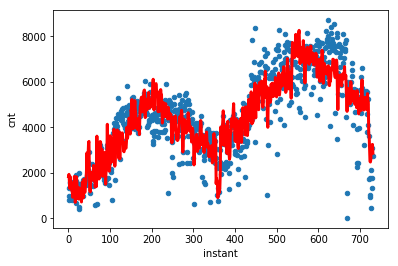

In [18]:
ax = projected_data.plot.scatter(x='instant',y='cnt')
ax.plot(projected_data.loc[:,'instant'], ss.inverse_transform(models.loc['LinearRegression','model'].predict(projected_data.drop(columns=['instant','cnt']))), color='red', linewidth=3)